In [2]:
import pandas as pd
import numpy as np
import re

def paranthesis_remover(entry):
    return re.sub('\(.+?\)', '', str(entry))

def one_hot_encoder(file_name):
    imdb_budget_df = pd.read_csv(file_name)
    
    # Include only movies, and successful API calls
    reduced_imdb = imdb_budget_df.loc[imdb_budget_df['Response'] == True]
    reduced_imdb = imdb_budget_df.loc[imdb_budget_df['Type'] == 'movie']
    
    # drop extra columns
    reduced_imdb.columns = map(str.lower, reduced_imdb.columns)
    return reduced_imdb.drop(columns=['actors', 'director', 'genre', 'language', 'country', 'dvd', 'writer', 'unnamed: 0', 'awards',
                                      'plot', 'error', 'poster', 'production',
                                      'rated', 'ratings', 'released', 'response', 'runtime',
                                      'type', 'website', 'imdbid', 'totalseasons'])
    

In [3]:
imdb = one_hot_encoder('raw_data/combined_imdb_data.csv')

In [4]:
def preprocess(df):
    df['boxoffice'] = df['boxoffice'].apply(lambda x: ''.join([ch for ch in x if ch.isdigit()]))
    df['imdbvotes'] = df['imdbvotes'].apply(lambda x: ''.join([ch for ch in x if ch.isdigit()]))
    return df

budget_df = imdb.dropna(subset=['boxoffice'])
budget_df = preprocess(budget_df)

D:\Users\brain\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Users\brain\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
# Get IMDB movie metadata
# script_csv_path = "/content/drive/My Drive/ENSF 519/Data/combined_imdb_data.csv"
imdb_csv_path = "./processed_data/combined_imdb_data.csv"
imdb_data = pd.read_csv(imdb_csv_path, index_col=0).rename(columns={"Title": "title"})
# imdb_data = imdb_data.drop(columns=["Awards", "Country", "DVD", "Ratings", "Director"])
# print(imdb_data.columns)
# display(imdb_data)
imdb_data = imdb_data[imdb_data['Response'] == True]
imdb_data = imdb_data[['title', 'BoxOffice', 'Metascore', 'Runtime', 'Year', 'imdbRating', 'imdbVotes']]
imdb_data['BoxOffice'] = imdb_data['BoxOffice'].str.replace(r'[\$\,]', "")
imdb_data['BoxOffice'] = imdb_data['BoxOffice'].str.replace(r'', "0")
imdb_data = imdb_data.fillna(0)
imdb_data['BoxOffice'] = imdb_data['BoxOffice'].astype(float)
imdb_data['Metascore'] = imdb_data['Metascore'].astype(float)
imdb_data['Runtime'] = imdb_data['Runtime'].str.replace(r' min', "")
imdb_data['Runtime'] = imdb_data['Runtime'].astype(float)
imdb_data['Year'] = imdb_data['Year'].str.replace('(\–\d*)', "")
imdb_data['Year'] = imdb_data['Year'].astype(float)
imdb_data['imdbVotes'] = imdb_data['imdbVotes'].str.replace(',', "")
imdb_data['imdbVotes'] = imdb_data['imdbVotes'].astype(float)
# print(imdb_data.dtypes)
# display(imdb_data)

# Get Oscar labels
# oscar_labels_path = "/content/drive/My Drive/ENSF 519/Data/oscar_data.csv"
oscar_labels_path = "./processed_data/oscar_data.csv"
oscar_label = pd.read_csv(oscar_labels_path).rename(columns={"entity": "title", "category": "nominated", "winner": "won"})
oscar_label = oscar_label.drop(columns=["year"])
oscar_label["nominated"] = True
# display(oscar_label)

# Merge script and Oscar data
imdb_oscar_df = pd.merge(imdb_data, oscar_label, how="outer", on="title")
imdb_oscar_df = imdb_oscar_df.dropna(subset=['BoxOffice'])
imdb_oscar_df = imdb_oscar_df.fillna(False)
imdb_oscar_df['nominated'].astype('bool')
imdb_oscar_df['won'].astype('bool')

# Only choose movies that were nominated and won
imdb_oscar_df = imdb_oscar_df[imdb_oscar_df['nominated'] == imdb_oscar_df['won']].drop_duplicates()
imdb_oscar_df = imdb_oscar_df.drop(columns=['nominated', 'title'])
imdb_oscar_df['won'] = imdb_oscar_df['won'].astype(int)
imdb_oscar_df = imdb_oscar_df.reset_index(drop=True)

display(imdb_oscar_df)

,BoxOffice,Metascore,Runtime,Year,imdbRating,imdbVotes,won
0,0.000000e+00,0.0,30,2009.0,7.8,41,0
1,0.000000e+00,54.0,106,1987.0,6.7,29262,0
2,5.090408e+15,76.0,103,2016.0,7.2,267933,0
3,0.000000e+00,70.0,97,1999.0,7.3,275872,0
4,0.000000e+00,12.0,101,1983.0,6.3,6022,0
...,...,...,...,...,...,...,...
4260,3.040102e+17,78.0,108,2016.0,8.0,394091,1
4261,0.000000e+00,0.0,142,1964.0,7.7,19035,1
4262,0.000000e+00,0.0,104,1972.0,7.2,4442,0
4263,0.000000e+00,0.0,98,1958.0,6.5,2114,0


In [23]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

features = imdb_oscar_df.drop(columns=['won'])
labels = imdb_oscar_df['won']

X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=69)
X_train = X_train.dropna()
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

D:\Users\brain\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  import sys


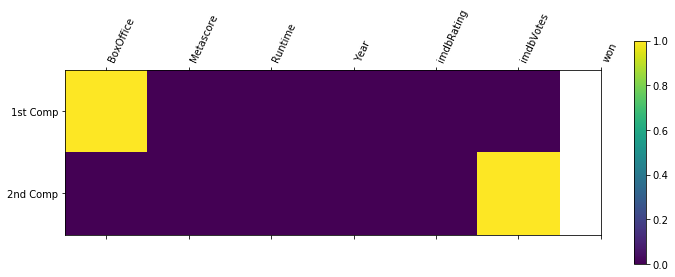

In [25]:
import matplotlib.pyplot as plt

plt.matshow(pca.components_,cmap='viridis')
plt.yticks([0,1],['1st Comp','2nd Comp'],fontsize=10)
plt.colorbar()
plt.xticks(range(len(imdb_oscar_df.columns)),imdb_oscar_df.columns,rotation=65,ha='left')
plt.tight_layout()
plt.show()